In [ ]:
import torch
from torchinfo import summary
import torch.optim as optim
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn.functional as nnf
import torch.nn as nn
from torchvision import transforms
from piq import psnr, ssim, brisque, LPIPS

from utils.metrics import validation_scores
from models.completion.AE import AE256
from utils.datasets import Pokemon_SR_completion


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
current = os.getcwd()
image_folder = current + "/pokemon_jpg/"  # Change this to your image folder path
#image_size = (64, 64)  # Resize images to this size (optional)

images = []


for filename in tqdm(sorted(os.listdir(image_folder))):
    if filename.endswith((".png", ".jpg", ".jpeg")):
        img_path = os.path.join(image_folder, filename)
        img = Image.open(img_path).convert("RGB")
        #img = img.resize(image_size)  # Optional resize
        img_array = np.array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)

images_np = np.stack(images)

np.save("pokemon.npy", images_np)
poke = np.load("pokemon.npy")
plt.imshow(poke[0])
print("Saved dataset.npy with shape:", images_np.shape)

 58%|█████▊    | 471/819 [00:00<00:00, 637.12it/s]


KeyboardInterrupt: 

In [ ]:
num_epochs = 1000
batch_size = 2
scalefactor = 8
latent_dims = [64]
channels = [32, 64, 128, 256]
in_channels = 3
base_width = 32
model = AE256(in_channels=in_channels,
                          latent_dims=latent_dims,
                          channels=channels,
                          base_width=base_width
                          ).to(device)
print(model.sample(torch.randn(1, in_channels, base_width, base_width).to(device)).shape)
summary(model, input_size=[(1, in_channels, base_width, base_width), (1, in_channels, 256, 256)])

torch.Size([1, 3, 256, 256])


Layer (type:depth-idx)                   Output Shape              Param #
AE                                       [1, 3, 256, 256]          --
├─AELREncoder: 1-1                       [1, 64]                   --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           128
│    └─Conv2d: 2-2                       [1, 64, 16, 16]           32,832
│    └─Conv2d: 2-3                       [1, 128, 8, 8]            131,200
│    └─Linear: 2-4                       [1, 64]                   524,352
├─AEDecoder: 1-2                         [1, 3, 256, 256]          --
│    └─Linear: 2-5                       [1, 262144]               17,039,360
│    └─ConvTranspose2d: 2-6              [1, 128, 64, 64]          524,416
│    └─ConvTranspose2d: 2-7              [1, 64, 128, 128]         131,136
│    └─ConvTranspose2d: 2-8              [1, 32, 256, 256]         32,800
│    └─Conv2d: 2-9                       [1, 3, 256, 256]          99
Total params: 18,416,323
Trainable params: 18,41

Dataset Loaded: 655 training samples, 164 validation samples


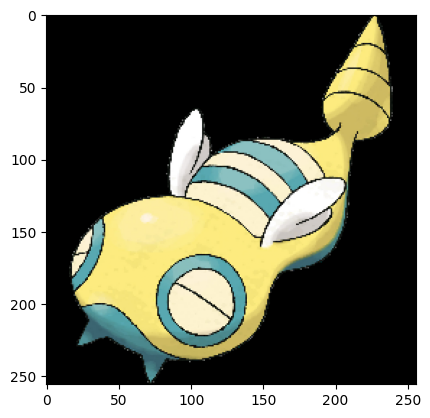

In [4]:


train_dataset = Pokemon_SR_completion(scale_factor=scalefactor, split='train')
test_dataset = Pokemon_SR_completion(scale_factor=scalefactor, split='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_train_data = len(train_dataset)
print(f"Dataset Loaded: {len(train_dataset)} training samples, {len(test_dataset)} validation samples")
plt.imshow(train_dataset[0][0].permute(1, 2, 0).cpu().numpy())
#means = []
#stds = []
#for img in train_loader:
#    means.append(torch.mean(img[1]))
#    stds.append(torch.std(img[1]))

#mean = torch.mean(torch.tensor(means))
#std = torch.mean(torch.tensor(stds))

In [5]:
#print(mean,std)

In [5]:
# Adam opt
optimizer = optim.Adam(model.parameters(), lr=1e-3)
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features[:20]
        for param in vgg.parameters():
            param.requires_grad = False  # Freeze VGG weights
        self.vgg = vgg

    def forward(self, pred, target):
        pred_features = self.vgg(pred)
        target_features = self.vgg(target)
        return nnf.mse_loss(pred_features, target_features)  # Feature-level loss
perceptual_loss = PerceptualLoss().to(device)
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

c:\Users\Kevin\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# means1, stds1 = [], []
# means2, stds2 = [], []
# means3, stds3 = [], []
# for HR, LR, LR_UP in train_loader:
#     means1.append(torch.mean(HR[1][0]))
#     stds1.append(torch.std(HR[1][0]))
#     means2.append(torch.mean(HR[1][1]))
#     stds2.append(torch.std(HR[1][1]))
#     means3.append(torch.mean(HR [1][2]))
#     stds3.append(torch.std(HR[1][2]))


# mean1 = torch.mean(torch.tensor(means1))
# std1 = torch.mean(torch.tensor(stds1))
# mean2 = torch.mean(torch.tensor(means2))
# std2 = torch.mean(torch.tensor(stds2))
# mean3 = torch.mean(torch.tensor(means3))
# std3 = torch.mean(torch.tensor(stds3))
# print(mean1, std1)
# print(mean2, std2)
# print(mean3, std3)

In [6]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0


    for HR, LR, LR_UP in train_loader:

        optimizer.zero_grad()
        recon_imgs = model(LR, LR_UP)
        #plt.imshow(HR[0].permute(1, 2, 0).detach().cpu().numpy())
        #plt.show()
        #normalize = transforms.Normalize(mean=[0.49139968, 0.48215841, 0.44653091], std=[0.24703223, 0.24348513, 0.26158784])
        #HR = normalize(HR)
        #HR = transforms.Resize((224, 224))(HR)
        #recon_imgs = normalize(recon_imgs)
        #recon_imgs = transforms.Resize((224, 224))(recon_imgs)
        loss = ssim(recon_imgs, HR)
        loss = -loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.2f}")
    model.loss.append(total_loss)


Epoch [1/1000] | Loss: -224.15
Epoch [2/1000] | Loss: -225.63
Epoch [3/1000] | Loss: -225.58
Epoch [4/1000] | Loss: -225.51
Epoch [5/1000] | Loss: -225.71
Epoch [6/1000] | Loss: -225.83
Epoch [7/1000] | Loss: -226.19
Epoch [8/1000] | Loss: -226.42
Epoch [9/1000] | Loss: -226.86
Epoch [10/1000] | Loss: -227.58
Epoch [11/1000] | Loss: -228.45
Epoch [12/1000] | Loss: -229.55
Epoch [13/1000] | Loss: -231.38
Epoch [14/1000] | Loss: -233.58
Epoch [15/1000] | Loss: -236.09
Epoch [16/1000] | Loss: -239.37
Epoch [17/1000] | Loss: -242.84
Epoch [18/1000] | Loss: -245.79
Epoch [19/1000] | Loss: -249.16
Epoch [20/1000] | Loss: -252.33
Epoch [21/1000] | Loss: -254.85
Epoch [22/1000] | Loss: -257.40
Epoch [23/1000] | Loss: -259.85
Epoch [24/1000] | Loss: -261.60
Epoch [25/1000] | Loss: -263.39
Epoch [26/1000] | Loss: -265.37
Epoch [27/1000] | Loss: -266.68
Epoch [28/1000] | Loss: -267.94
Epoch [29/1000] | Loss: -269.45
Epoch [30/1000] | Loss: -270.45
Epoch [31/1000] | Loss: -271.24
Epoch [32/1000] |

[]

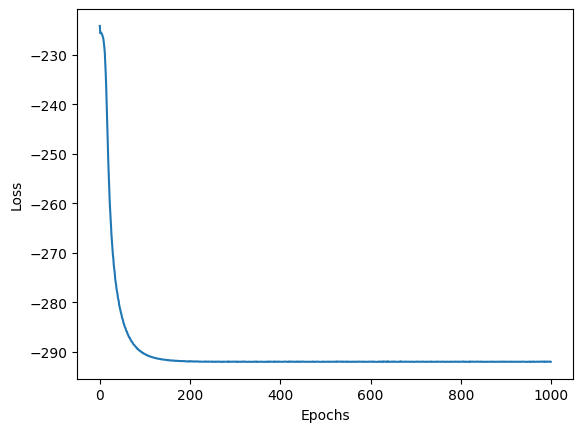

In [7]:
plt.plot(model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [8]:
HR, LR, LR_UP = test_dataset.get_samples(32)
SR = model.sample(LR)

In [9]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(4, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')
            axs[3, i].set_title('Low Resolution Upscaled')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

        axs[3, i].imshow(LR_UP[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[3, i].axis('off')

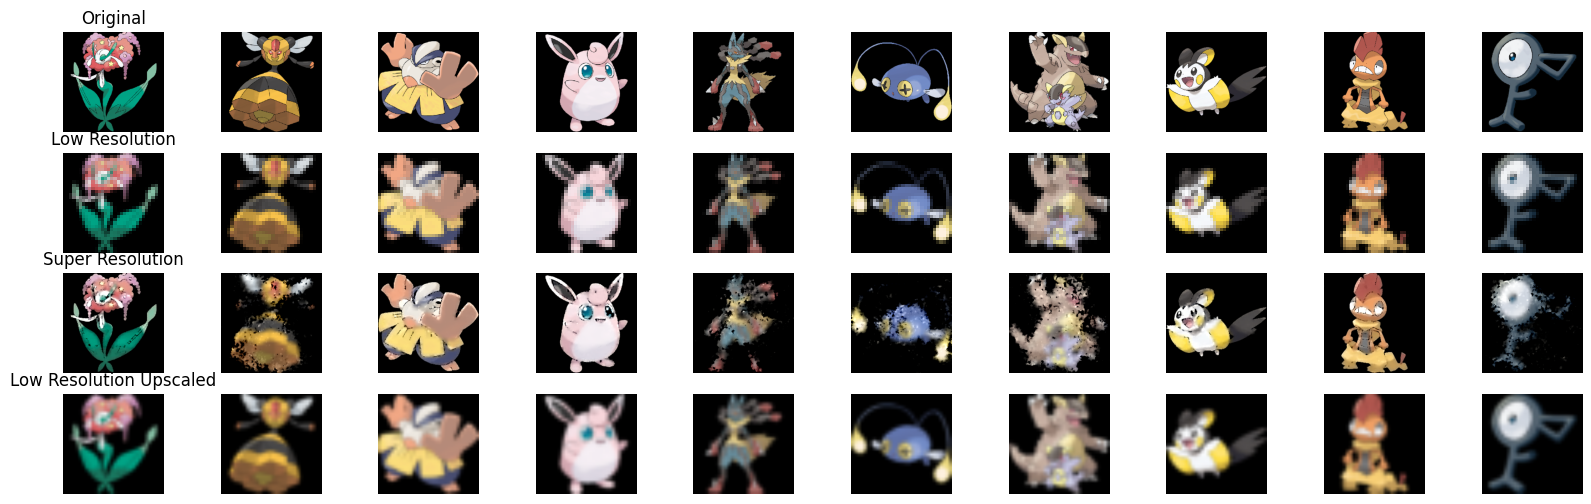

In [10]:
show_image(HR, LR, SR, 10)

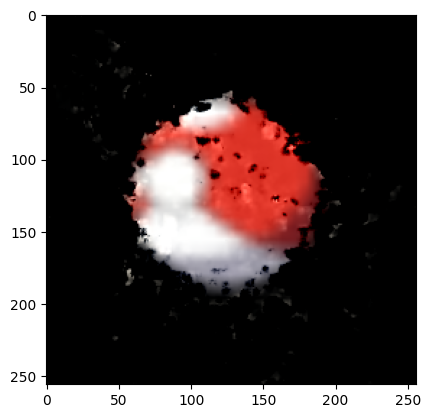

In [18]:
img = Image.open("fake_voltorb2.jpg").convert("RGB")
#img = img.resize(image_size)  # Optional resize
#img_array = np.array(img, dtype=torch.float32) / 255.0  # Normalize to [0, 1]
plt.imshow(img)
img_downscaled = transforms.Resize((32, 32))(transforms.ToTensor()(img)).unsqueeze(0).to(device)
plt.imshow(img_downscaled[0].permute(1, 2, 0).detach().cpu().numpy())
img_downscaled_upscaled = transforms.Resize((256, 256))(img_downscaled)
img_superresolution = model.sample(img_downscaled)
plt.imshow(img_superresolution[0].permute(1, 2, 0).detach().cpu().numpy())
#plt.imshow(img_downscaled [0].permute(1, 2, 0).detach().cpu().numpy())

In [14]:
_, _ , psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

PSNR: 21.767515182495117
SSIM: 0.8483917117118835
LPIPS: 0.196418896317482
BRISQUE: 51.86469268798828
PSNR Consistency: 31.333192825317383
MSE Diversity: 3.281403587806204e-16
LPIPS Diversity: 5.754903720112266e-12
